In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from scipy.sparse.linalg import norm
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime as datetime
from sklearn.manifold import TSNE

In [2]:
user_year_to_class = {}
min_year = 2005
with open("yelp_academic_dataset_user.json") as f:
    for l in f:
        line = json.loads(l)
        user = line["user_id"]
        
        elites = line["elite"]
        if "None" not in elites:
            for yr in elites:
                yr_int = int(yr)
                if yr_int - 1 >= min_year and str(yr_int - 1) not in elites:
                    user_year_to_class[(user, yr_int - 1)] = 2
                if str(yr_int + 1) in elites:
                    user_year_to_class[(user, yr_int)] = 1
                else:
                    user_year_to_class[(user, yr_int)] = 3

In [3]:
print user_year_to_class.items()[:10]

[((u'FBQ8aB_55GqvtaROAzU4Ww', 2008), 2), ((u'blrWvPePSv87aU9hV1Zd8Q', 2010), 2), ((u'XL1IkA7cKNOUFccndX2i_w', 2009), 1), ((u'ifZJeZuTTj4dfEoR29I6bA', 2011), 1), ((u'41HLwXnR0Lm3NUp01cIOQg', 2012), 1), ((u'ITf8PiWzmTzcZu3kRWEoGg', 2014), 2), ((u'-hKniZN2OdshWLHYuj21jQ', 2017), 3), ((u'd2ZZr4-jMlK0CWFOyALGNg', 2010), 3), ((u'lHGI9cubh0g4wG0LFt1rdA', 2016), 3), ((u'vJGJSKj3DRIPpQqqz_9gnQ', 2014), 2)]


In [4]:
def user_class(user, year):
    if (user, year) in user_year_to_class:
        return user_year_to_class[(user, year)]
    else:
        return 0

In [5]:
reviews = []
texts = []
classes = []
with open("yelp_academic_dataset_review.json") as f:
    for l in f:
        if len(reviews) > 10000:
            break
        line = json.loads(l)
        reviews.append(line)
        texts.append(line["text"])
        
        date = datetime.datetime.strptime(line['date'], '%Y-%m-%d')
        year = int(date.strftime('%Y'))
    
        user = line["user_id"]
        clss = user_class(user, year)
        classes.append(clss)

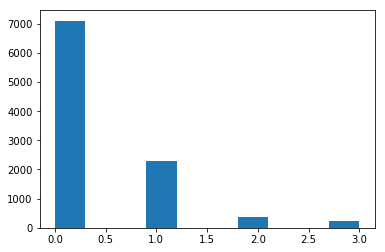

In [6]:
plt.hist(classes)
plt.show()

In [49]:
tfidf = TfidfVectorizer(norm=None)
trans = tfidf.fit_transform(texts)

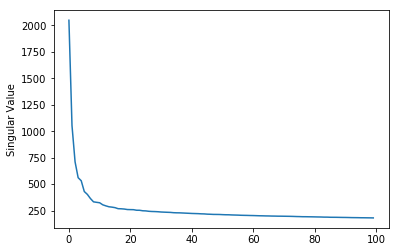

In [50]:
test_kval = 100

s= svds(trans, k=test_kval, return_singular_vectors=False)
plt.plot(range(test_kval), sorted(s, reverse=True))
plt.ylabel("Singular Value")
plt.show()

In [9]:
chosen_kval = 20
u, s, v = svds(trans, k=chosen_kval)

model = TSNE(n_components=2)
reduced = model.fit_transform(u)

### Plot T-SNE output for all of the reduced reviews

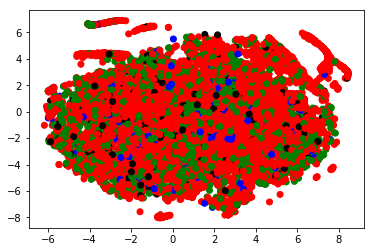

In [10]:
cmap = {0:"red", 1:"green", 2:"black", 3:"blue"}
colors = [cmap[cls] for cls in classes]
plt.scatter(reduced[:, 0], reduced[:, 1], c=colors)
plt.show()

### Plot T-SNE output for only classes 1-3 (exluding the class that was never elite), we see that there isn't much clustering...

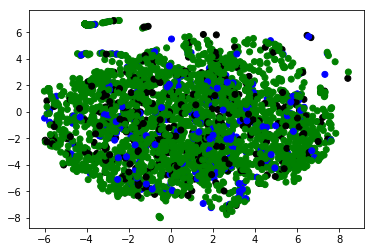

In [11]:
non_zero = []
non_zero_classes = []
for ind, cls in enumerate(classes):
    if cls != 0:
        non_zero.append(reduced[ind])
        non_zero_classes.append(cls)
colors = [cmap[cls] for cls in non_zero_classes]
plt.scatter(np.array(non_zero)[:, 0], np.array(non_zero)[:, 1], c=colors)
plt.show()

In [14]:
chosen_kval = 20
u, s, v = svds(trans, k=chosen_kval)

model = TSNE(n_components=3)
reduced = model.fit_transform(u)

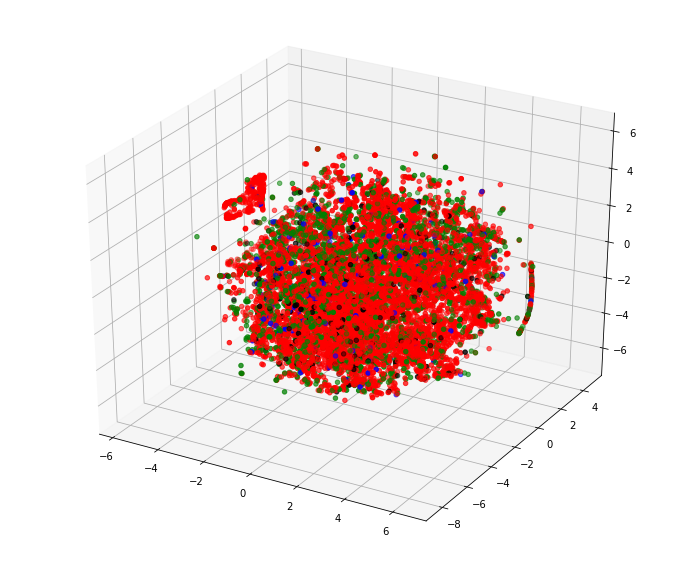

In [20]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = [cmap[cls] for cls in classes]
ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=colors)
plt.show()

### Look into differences in the tf-idf lengths and non-zero features(aka unique words used)

In [51]:
class_norms = {}
for ind, row in enumerate(trans):
    if classes[ind] not in class_norms:
        class_norms[classes[ind]] = [norm(row)]
    else:
        class_norms[classes[ind]].append(norm(row))
for cls, norms in class_norms.items():
    print "Class {}, Mean tf-idf review length: {}".format(cls, np.mean(norms))

Class 0, Mean tf-idf review length: 48.7535498133
Class 1, Mean tf-idf review length: 59.9813739801
Class 2, Mean tf-idf review length: 53.2583999647
Class 3, Mean tf-idf review length: 54.801801752


In [52]:
class_features = {}
for ind, row in enumerate(trans):
    if classes[ind] not in class_features:
        class_features[classes[ind]] = [len(row.data)]
    else:
        class_features[classes[ind]].append(len(row.data))
for cls, feats in class_features.items():
    print "Class {}, Mean number of non-zero features: {}".format(cls, np.mean(feats))

Class 0, Mean number of non-zero features: 71.599042658
Class 1, Mean number of non-zero features: 96.9514310494
Class 2, Mean number of non-zero features: 85.7845303867
Class 3, Mean number of non-zero features: 85.5304347826


### Look at the largest differences (by tf-idf weights) between words used in the 4 different classes

In [59]:
#need to normalize the tfidf
norm_tfidf = TfidfVectorizer(stop_words="english")
norm_trans = norm_tfidf.fit_transform(texts)
features = norm_tfidf.get_feature_names()

In [60]:
class_counts = {}
for ind, row in enumerate(norm_trans):
    cls = classes[ind]
    if cls not in class_counts:
        class_counts[cls] = [row.toarray()[0], 1]
    else:
        class_counts[cls][0] += row.toarray()[0]
        class_counts[cls][1] += 1
class_avg = {cls: counts[0]/counts[1] for (cls, counts) in class_counts.items()}

for cls, avg in class_avg.items():
    for cls2, avg2 in class_avg.items():
        if cls < cls2:
            similarities = []
            for i in range(len(avg)):
                similarities.append((i, abs(avg[i]-avg2[i])))
            print "\nClass {} and Class {}".format(cls, cls2)
            for feature, diff in sorted(similarities, key=lambda x:x[1], reverse=True)[:5]:
                print "{}: {}".format(features[feature], diff)


Class 0 and Class 1
und: 0.00842066813947
really: 0.00695138159535
recommend: 0.00663483163746
service: 0.00633092716165
die: 0.00616449917056

Class 0 and Class 2
good: 0.00891694756617
place: 0.00869678175581
really: 0.00774392765108
bar: 0.00657485322991
like: 0.00651546399255

Class 0 and Class 3
great: 0.0105030802777
really: 0.00864820869837
probably: 0.00848922088974
like: 0.00836688331364
pretty: 0.00774633919409

Class 1 and Class 2
place: 0.00713655864559
food: 0.00653751570841
great: 0.00652922303507
good: 0.00612125056966
service: 0.00508530834542

Class 1 and Class 3
salon: 0.00631905548788
probably: 0.0061440253558
good: 0.00603839822967
coffee: 0.00601970713685
decent: 0.00539131893022

Class 2 and Class 3
good: 0.0121596487993
great: 0.0112986637534
pizza: 0.00829057545352
place: 0.00767995664263
coffee: 0.00766820794188
